In [4]:
import pandas as pd
import os

os.chdir("../")
from polapy.aggregate import dhondt
from polapy.stats import quota
from polapy.competitiveness import blais_lago

In [2]:
import numpy as np

In [5]:
df = pd.DataFrame([
    ["PSOE", 154579],
    ["PP", 84173],
    ["IU", 15097],
    ["PA", 14542],
    ["PSA", 1055],
    ["CENB", 351],
    ["PTPRE", 248],
    ["PH", 190],
    ["CDS", 162],
    ["A", 150],
    ["IR", 145],
    ["DN", 116],
    ["FE", 93],
    ["FE DE LAS J", 91],
    ["FA", 68],
    ["MSR", 52],
    ["Blank", 4009],
    ["Null", 1907]
], columns=["Party", "Votes"])
df.head()

blais_lago(
    df,
    candidate="Party",
    votes="Votes",
    n_seats=1
)


(9.043829504598813,
           Party  distance     seats     value
 10          MSR  154527.0  154527.0  0.557803
 5            FA  154511.0  154511.0  0.557745
 7   FE DE LAS J  154488.0  154488.0  0.557662
 6            FE  154486.0  154486.0  0.557655
 4            DN  154463.0  154463.0  0.557572
 8            IR  154434.0  154434.0  0.557467
 0             A  154429.0  154429.0  0.557449
 2           CDS  154417.0  154417.0  0.557406
 13           PH  154389.0  154389.0  0.557305
 17        PTPRE  154331.0  154331.0  0.557095
 3          CENB  154228.0  154228.0  0.556724
 15          PSA  153524.0  153524.0  0.554182
 11         Null  152672.0  152672.0  0.551107
 1         Blank  150570.0  150570.0  0.543519
 12           PA  140037.0  140037.0  0.505498
 9            IU  139482.0  139482.0  0.503494
 14           PP   70406.0   70406.0  0.254148
 16         PSOE       0.0       0.0  0.000000)

In [ ]:
def proportional(
    input_df,
    candidate="party",
    votes="votes",
    n_seats=1,
    method="hare"
):
    q = quota(method=method, n_votes=input_df[votes].sum(), n_seats=n_seats)
    output_df = input_df.copy()
    output_df["quota"] = q
    output_df["dividend"] = output_df[votes] / q
    
    output_df["seats"] = output_df["dividend"].apply(lambda x: max(np.floor(x), 1))
    output_df["cumseats"] = output_df["seats"].cumsum()

    output_df = output_df[output_df["cumseats"] <= n_seats]
    output_df = output_df.drop(columns=["cumseats", "votes", "quota"])

    return output_df

In [ ]:
def blais_lago(
    input_df,
    candidate="party",
    votes="votes",
    n_seats=1,
    system="dhondt"
):
    if system == "dhondt":
        data, quot = dhondt(input_df, party=candidate, votes=votes, n_seats=n_seats, quota=True)
        seats = dhondt(input_df, party=candidate, votes=votes, n_seats=n_seats, quota=False)

        data["distance"] = data["quota"] - quot
        n_seats = data[data["distance"] >= 0]
        data = data[data["distance"] < 0]

        data["distance"] = data["quota"] - data.apply(lambda x: n_seats[n_seats[candidate] != x[candidate]]["quota"].min(), axis=1)
        data["distance"] *= -1

        output_df = pd.merge(
            data.groupby(candidate).agg({"distance": "min"}).reset_index(),
            seats,
            on=candidate,
            how="outer"
        )
        output_df["seats"] = output_df["seats"].fillna(0) + 1
        output_df["seats"] = output_df["distance"] * output_df["seats"]

        output_df = output_df.sort_values("seats", ascending=False)
        output_df = output_df.fillna(0)
    
    elif system == "hare":
        seats = proportional(input_df, candidate=candidate, votes=votes, method=system, n_seats=n_seats)
        q = quota(method=system, n_votes=input_df[votes].sum(), n_seats=n_seats)
        data = input_df.copy()
        data["quota"] = q

        output_df = pd.merge(
            data,
            seats,
            on=candidate,
            how="outer"
        )

        output_df["seats"] = output_df["seats"].fillna(0).apply(lambda x: (2*x + 1)/2 + 0.001)
        output_df["seats"] = q * output_df["seats"] - output_df["votes"]

        output_df = output_df.sort_values("seats", ascending=False)
        output_df = output_df.fillna(0)

    
    elif system == "smp":
        output_df = input_df.copy()
        output_df["seats"] = input_df[votes].max() - output_df["votes"]

    output_df["value"] = output_df["seats"] / (input_df[votes].sum()/n_seats)
        
    return output_df["value"].sum(), output_df

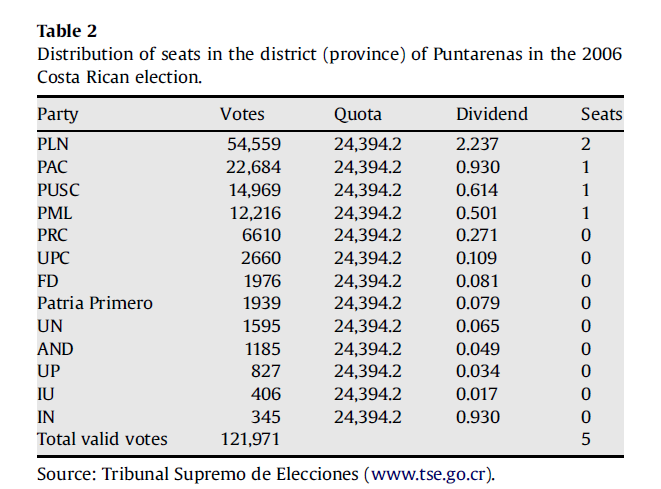

In [ ]:
df = pd.DataFrame([
    ["PLN", 54559],
    ["PAC", 22684],
    ["PUSC", 14969],
    ["PML", 12216],
    ["PRC", 6610],
    ["UPC", 2660],
    ["FD", 1976],
    ["Patria Primero", 1939],
    ["UN", 1595],
    ["AND", 1185],
    ["UP", 827],
    ["IU", 406],
    ["IN", 345]
], columns=["party", "votes"])

blais_lago(df, system="hare", n_seats=5)
# proportional(df, quota="hare", n_seats=5)

(6.512905608710267,
              party  votes  quota  dividend      seats     value
 3              PML  12216  24394  0.500779  24399.394  1.000213
 2             PUSC  14969  24394  0.613635  21646.394  0.887358
 1              PAC  22684  24394  0.929901  13931.394  0.571095
 12              IN    345  24394  0.000000  11876.394  0.486853
 11              IU    406  24394  0.000000  11815.394  0.484353
 10              UP    827  24394  0.000000  11394.394  0.467094
 9              AND   1185  24394  0.000000  11036.394  0.452419
 8               UN   1595  24394  0.000000  10626.394  0.435611
 7   Patria Primero   1939  24394  0.000000  10282.394  0.421510
 6               FD   1976  24394  0.000000  10245.394  0.419993
 5              UPC   2660  24394  0.000000   9561.394  0.391954
 0              PLN  54559  24394  2.236575   6450.394  0.264423
 4              PRC   6610  24394  0.000000   5611.394  0.230030)

In [ ]:
quota(method="hare", n_votes=df.votes.sum(), n_seats=5)

24394